### Testing image dilation

Available tools:
1. cv2
2. scikit-image
3. scipy.ndimage.morphology 

In [33]:
import re, os, ast
from glob import glob
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.morphology import square, dilation, disk
from photutils.isophote import EllipseGeometry
from astropy.wcs import WCS

#### **Useful functions**

In [20]:
def elliptical_mask(data, geometry, maxsma):
    '''
    ----------------------------------------------------------------------
    Function to create elliptical mask at the center of the galaxy, given
    the primary matrix, geometry of ellipse and the maxsma of the ellipse
    ----------------------------------------------------------------------
    Returns: a boolean array with elements belonging to ellipse as True
    ----------------------------------------------------------------------
    '''
    from skimage.draw import ellipse
    cen_px = int(np.ceil(data.shape[0]/2))
    maxsma = int(np.ceil(maxsma))
    pa = geometry.pa
    if pa > np.pi:
        pa =- np.pi
    elif pa < -np.pi:
        pa += np.pi
    rr, cc = ellipse(cen_px, cen_px, maxsma*(1-geometry.eps), maxsma, rotation=pa+np.pi/2)
    img = np.zeros(data.shape, dtype=np.uint8)
    img[rr, cc] = 1
    img = img.T
    
    return img==1

def get_geometry_maxsma(obj_direc):
    if os.path.exists(obj_direc+"params.dat"):
        file = open(obj_direc+"params.dat", 'r').read()
        geom = ast.literal_eval(file)
        ellip_geometry = EllipseGeometry(x0=geom['x0'], y0=geom['y0'], sma=geom['sma'],\
                        eps=geom['eps'], pa=geom['pa']*np.pi/180.)
        return ellip_geometry, geom['maxsma']
    else:
        print("No input parameters file found!")
        return None, None

def get_final_mask_data(obj_direc):
    list_of_files = glob(obj_direc + 'mask*.fits') # * means all if need specific format then *.csv
    final_mask_path = max(list_of_files, key=os.path.getctime)
    final_mask_data = fits.getdata(final_mask_path)
    return final_mask_data

#### **Specify galaxy**

In [21]:
mag_range = "15to16"
obj = "FDS7DWARF326"
fld, gal_id = re.findall(r'\d+', obj)

obj_direc = "/home/srathi/data/SED/objects/{}/{}/".format(mag_range, obj)

#### **Load mask and add galaxy mask to it**

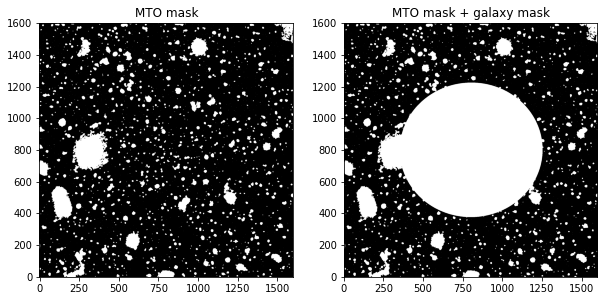

In [29]:
# r-band science image
data, hdr = fits.getdata(obj_direc + 'rF{}D{}_final.fits'.format(fld, gal_id.zfill(3)), header=True)

# loading mask
mask = get_final_mask_data(obj_direc)

# add elliptical mask over the galaxy
mask_w_gal = mask.copy()
geometry, maxsma = get_geometry_maxsma(obj_direc)
ellip_mask = elliptical_mask(mask, geometry, maxsma)
mask_w_gal[ellip_mask] = 1

# displaying the mask
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

im1 = ax1.imshow(mask, origin='lower', cmap="Greys_r")
ax1.set_title('MTO mask');

im2 = ax2.imshow(mask_w_gal, origin='lower', cmap="Greys_r")
ax2.set_title('MTO mask + galaxy mask');

### **1. Trying with OpenCV & skimage**
- using circular kernel (see the next markdown block)

Text(0.5, 1.0, 'dilation - skimage')

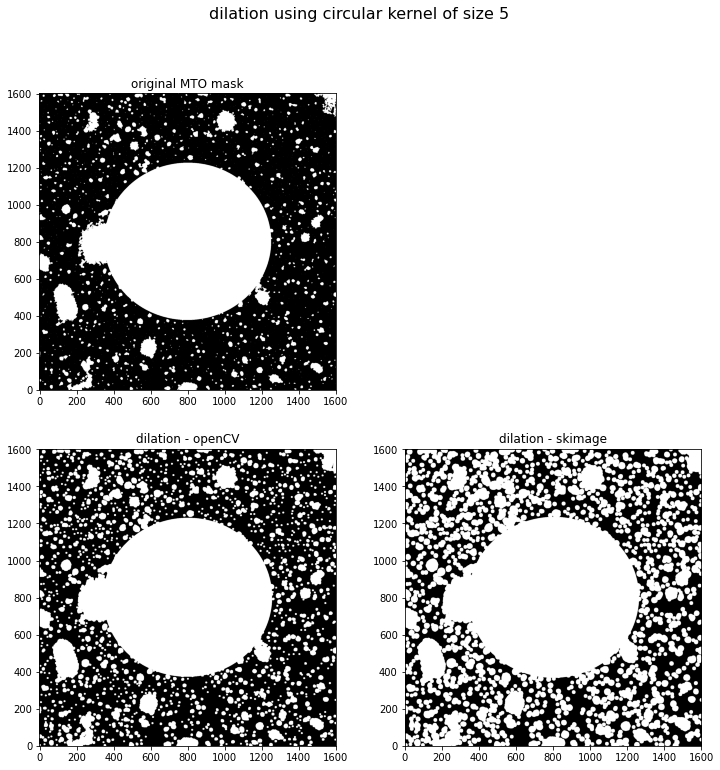

In [43]:
# convert
bin_mask1 = mask_w_gal.astype( np.uint8 )

# kernel size
s = 10

# openCV 
kernel_openCV = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (s,s))
dilation_openCV = cv2.dilate(bin_mask1, kernel_openCV, iterations=1)

# skimage
kernel_skimage = disk(s)
dilation_skimage = dilation(bin_mask1, kernel_skimage)

# plotting
fig = plt.figure(figsize=(12, 12))
fig.suptitle('dilation using circular kernel of size {}'.format(5), fontsize=16)

ax1 = fig.add_subplot(221)
# ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

im1 = ax1.imshow(bin_mask1, origin='lower', cmap="Greys_r")
ax1.set_title('original MTO mask')

im3 = ax3.imshow(dilation_openCV, origin='lower', cmap="Greys_r")
ax3.set_title('dilation - openCV'.format(s))

im4 = ax4.imshow(dilation_skimage, origin='lower', cmap="Greys_r")
ax4.set_title('dilation - skimage'.format(s))

#### **Overlaying the dilated masks**

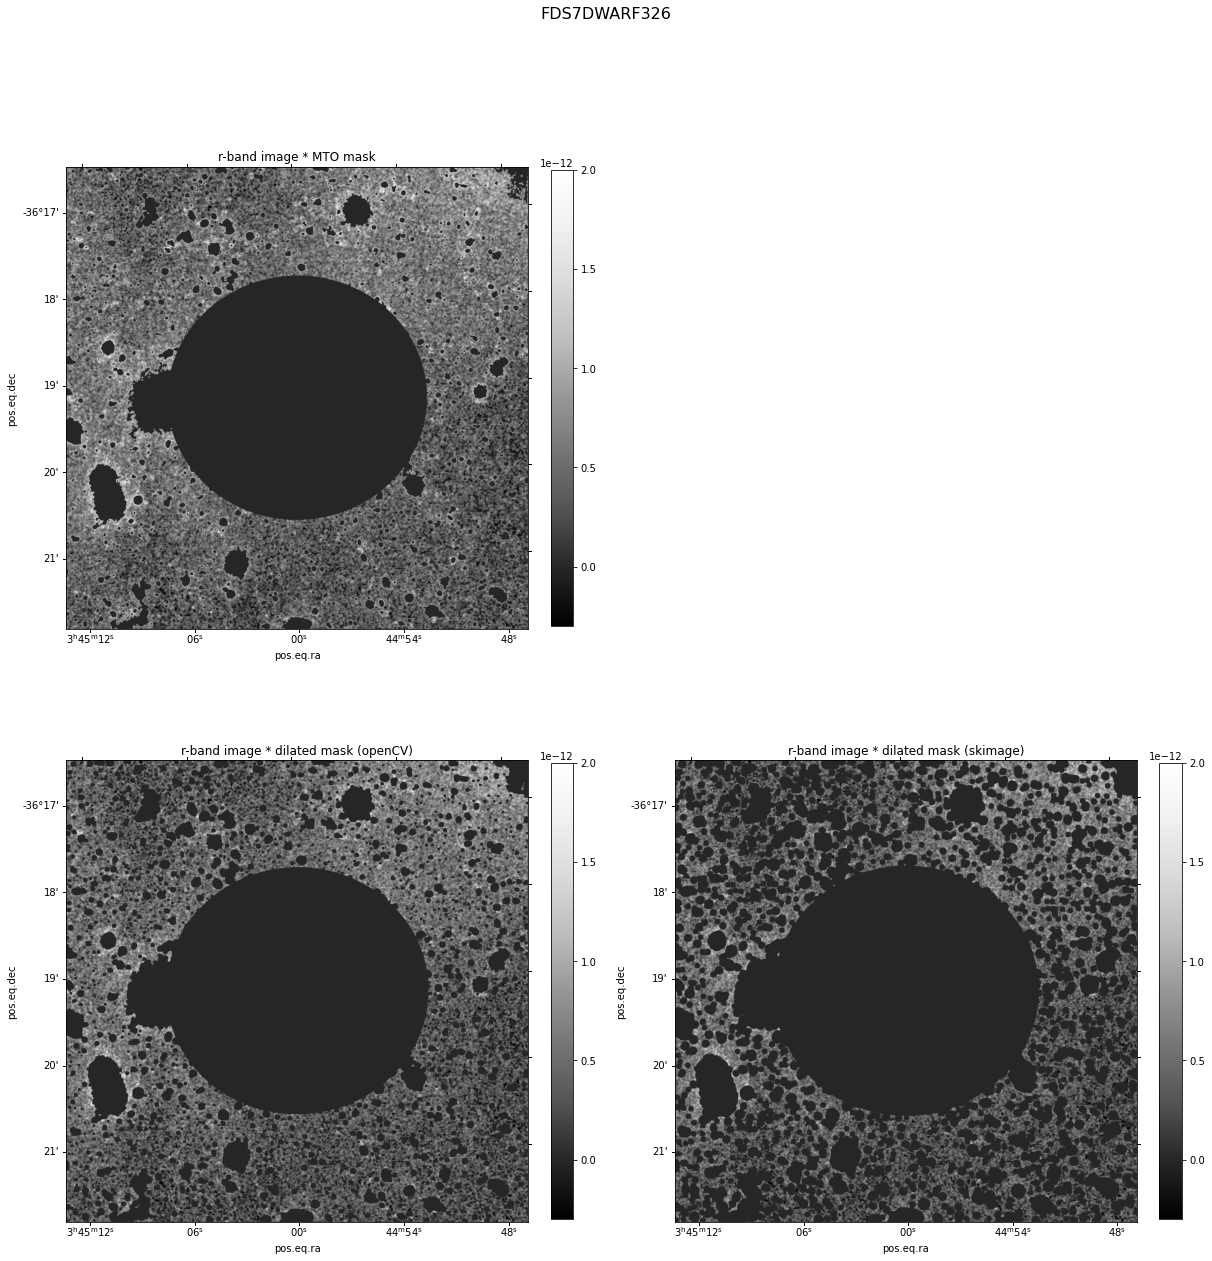

In [44]:
fig = plt.figure(figsize=(20, 20))
fig.suptitle(obj, fontsize=16)

wcs = WCS(hdr)

ax1 = fig.add_subplot(221, projection=wcs)
ax3 = fig.add_subplot(223, projection=wcs)
ax4 = fig.add_subplot(224, projection=wcs)

im1 = ax1.imshow(data*(1-mask_w_gal), origin='lower', cmap='Greys_r',
                vmin=-3e-13, vmax=2e-12)
ax1.set_title('r-band image * MTO mask')
cb1 = plt.colorbar(im1, ax=ax1, fraction=0.045, pad=0.045)

im3 = ax3.imshow(data*(1-dilation_openCV), origin='lower', cmap="Greys_r", 
                 vmin=-3e-13, vmax=2e-12)
ax3.set_title('r-band image * dilated mask (openCV)')
cb3 = plt.colorbar(im3, ax=ax3, fraction=0.045, pad=0.045)

im4 = ax4.imshow(data*(1-dilation_skimage), origin='lower', cmap="Greys_r", 
                 vmin=-3e-13, vmax=2e-12)
ax4.set_title('r-band image * dilated mask (skimage)')
cb4 = plt.colorbar(im4, ax=ax4, fraction=0.045, pad=0.045)

# ax.set_xlabel('RA')
# ax.set_ylabel('DEC')
# ax.set_title("Masked r-band image - {}".format(obj), fontsize=20)




### **2. Optimal kernel size**
- one kernel size to rule them all ??

### **Appendix: Comparing different dilation tools**
- openCV and skimage work in the exact same way
- Choice of kernel: square/rectangular or elliptical/circular - **NOTE: using circular kernel yeilds somewhat different results (see the cell above)**

Useful: 
- Circular kernel in openCV: `cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))`
- Circular kernel in skimage: `from skimage.morphology import disc` then use `disc(3)` as the kernel for dilation

Text(0.5, 1.0, 'difference (openCV - skimage)')

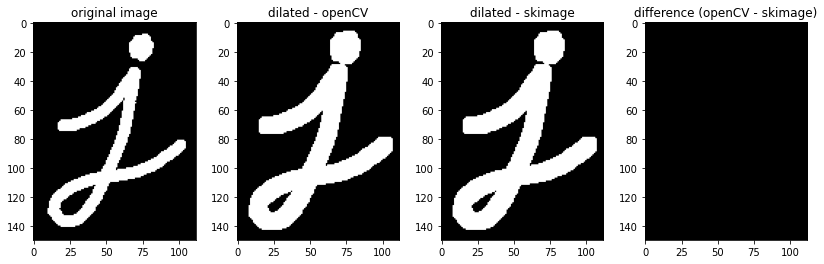

In [15]:
img = cv2.imread('/home/srathi/Desktop/j.png',0)

# different approaches
kernel = np.ones((5,5), np.uint8)
dilation_openCV = cv2.dilate(img, kernel, iterations = 1)
dilation_skimage = dilation(img, square(5))

# plotting 
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(141)
ax2 = fig.add_subplot(142)
ax3 = fig.add_subplot(143)
ax4 = fig.add_subplot(144)

# original
im1 = ax1.imshow(img, cmap='Greys_r')
ax1.set_title('original image')

im2 = ax2.imshow(dilation_openCV, cmap='Greys_r')
ax2.set_title('dilated - openCV')

im3 = ax3.imshow(dilation_skimage, cmap='Greys_r')
ax3.set_title('dilated - skimage')

im4 = ax4.imshow(dilation_openCV - dilation_skimage, cmap='Greys_r')
ax4.set_title('difference (openCV - skimage)')